<a href="https://colab.research.google.com/github/luxizh/EE62_Select_topic_for_Computer_Vision_Colab/blob/master/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
training start!
[1/30] - ptime: 131.57 loss_d: 1.696, loss_g: 1.137


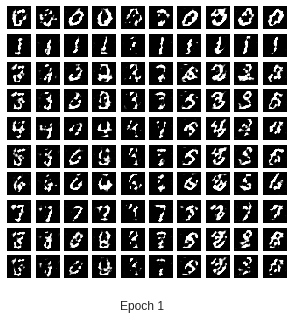

[2/30] - ptime: 120.76 loss_d: 1.437, loss_g: 1.482


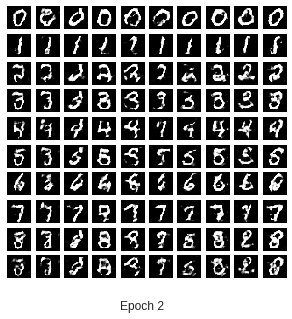

[3/30] - ptime: 136.07 loss_d: 1.694, loss_g: 1.201


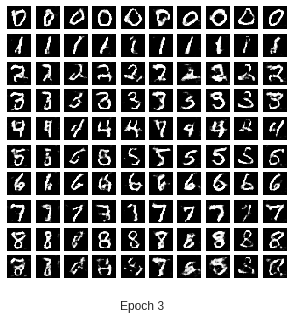

[4/30] - ptime: 136.68 loss_d: 1.772, loss_g: 1.117


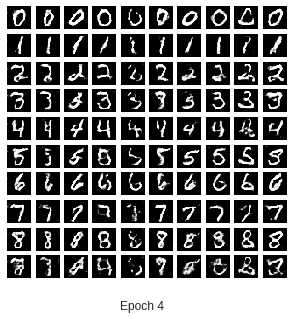

[5/30] - ptime: 120.64 loss_d: 1.876, loss_g: 1.090


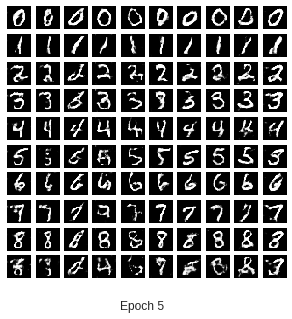

[6/30] - ptime: 118.79 loss_d: 1.896, loss_g: 0.914


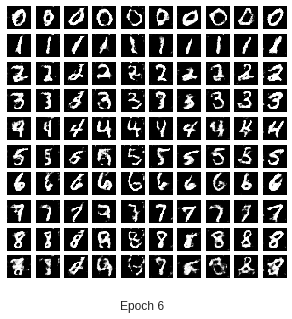

[7/30] - ptime: 119.17 loss_d: 2.224, loss_g: 1.289


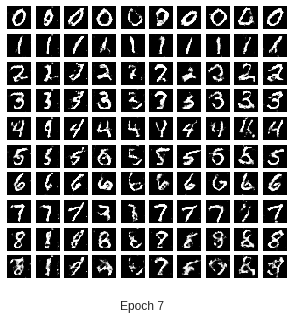

[8/30] - ptime: 121.19 loss_d: 2.041, loss_g: 1.012


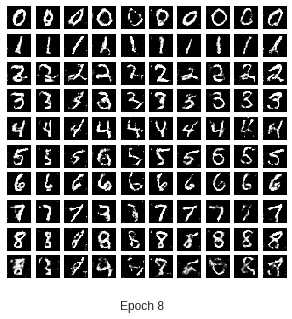

[9/30] - ptime: 127.04 loss_d: 1.801, loss_g: 1.012


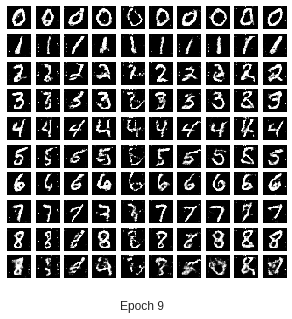

[10/30] - ptime: 138.20 loss_d: 2.442, loss_g: 1.161


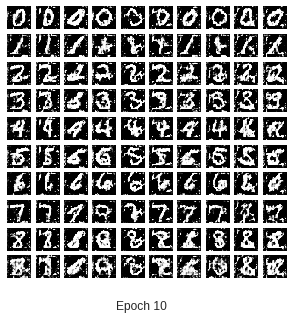

[11/30] - ptime: 132.77 loss_d: 2.163, loss_g: 1.200


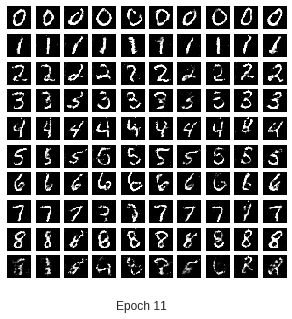

[12/30] - ptime: 120.67 loss_d: 1.853, loss_g: 0.851


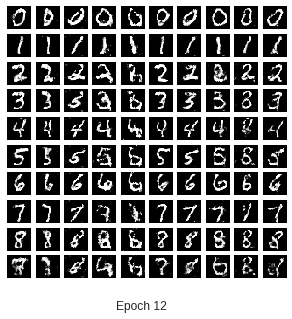

[13/30] - ptime: 121.80 loss_d: 2.311, loss_g: 1.241


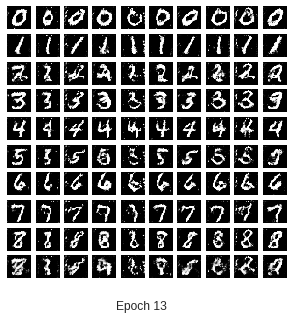

[14/30] - ptime: 132.39 loss_d: 2.431, loss_g: 1.117


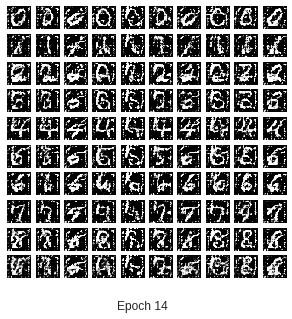

[15/30] - ptime: 137.65 loss_d: 3.027, loss_g: 0.410


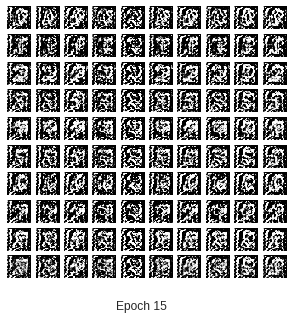

[16/30] - ptime: 127.93 loss_d: 2.480, loss_g: 0.801


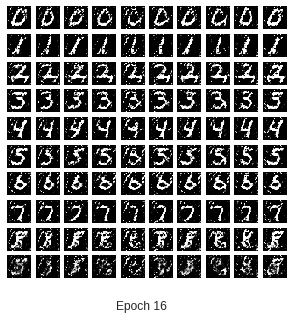

[17/30] - ptime: 120.11 loss_d: 1.838, loss_g: 0.506


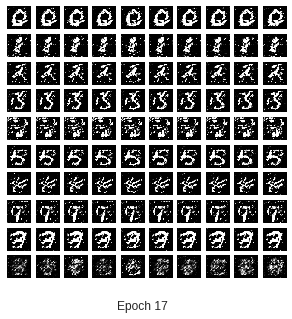

In [0]:
import os, time, itertools, imageio, pickle, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.reset_default_graph()
# leaky_relu
def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

# G(z)
def generator(x, y_label, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        # initializer
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b_init = tf.constant_initializer(0.0)

        # concat layer
        cat1 = tf.concat([x, y_label], 3)

        # 1st hidden layer 7*7*256
        deconv1 = tf.layers.conv2d_transpose(cat1, 256, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=w_init, bias_initializer=b_init)
        lrelu1 = lrelu(tf.layers.batch_normalization(deconv1, training=isTrain), 0.2)

        # 2nd hidden layer 14*14*128
        deconv2 = tf.layers.conv2d_transpose(lrelu1, 128, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        lrelu2 = lrelu(tf.layers.batch_normalization(deconv2, training=isTrain), 0.2)

        # output layer 28*28*1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 1, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        o = tf.nn.tanh(deconv3)

        return o

# D(x)
def discriminator(x, y_fill, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # initializer
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b_init = tf.constant_initializer(0.0)

        # concat layer
        cat1 = tf.concat([x, y_fill], 3)

        # 1st hidden layer
        conv1 = tf.layers.conv2d(cat1, 128, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        lrelu1 = lrelu(conv1, 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d(lrelu1, 256, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # output layer
        conv3 = tf.layers.conv2d(lrelu2, 1, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=w_init)
        o = tf.nn.sigmoid(conv3)

        return o, conv3

# preprocess
img_size = 28
onehot = np.eye(10)
temp_z_ = np.random.normal(0, 1, (10, 1, 1, 100))
fixed_z_ = temp_z_
fixed_y_ = np.zeros((10, 1))
for i in range(9):
    fixed_z_ = np.concatenate([fixed_z_, temp_z_], 0)
    temp = np.ones((10, 1)) + i
    fixed_y_ = np.concatenate([fixed_y_, temp], 0)

fixed_y_ = onehot[fixed_y_.astype(np.int32)].reshape((100, 1, 1, 10))
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, y_label: fixed_y_, isTrain: False})

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (img_size, img_size)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
    return test_images

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

# training parameters
batch_size = 100
lr = 0.0002
train_epoch = 2
#global_step = tf.Variable(0, trainable=False)
#lr = tf.train.exponential_decay(0.0002, global_step, 500, 0.95, staircase=True)
# load MNIST
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])

# variables : input
x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
y_label = tf.placeholder(tf.float32, shape=(None, 1, 1, 10))
y_fill = tf.placeholder(tf.float32, shape=(None, img_size, img_size, 10))
isTrain = tf.placeholder(dtype=tf.bool)

# networks : generator
G_z = generator(z, y_label, isTrain)

# networks : discriminator
D_real, D_real_logits = discriminator(x, y_fill, isTrain)
D_fake, D_fake_logits = discriminator(G_z, y_fill, isTrain, reuse=True)

# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1])))

# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# optimizer for each network

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optim = tf.train.AdamOptimizer(lr, beta1=0.5)
    #D_optim = optim.minimize(D_loss, global_step=global_step, var_list=D_vars)
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)

# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# MNIST resize and normalization
# train_set = tf.image.resize_images(mnist.train.images, [img_size, img_size]).eval()
# train_set = (train_set - 0.5) / 0.5  # normalization; range: -1 ~ 1
train_set = (mnist.train.images - 0.5) / 0.5
train_label = mnist.train.labels

# results save folder
root = 'MNIST_cDCGAN_results/'
model = 'MNIST_cDCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# training-loop
np.random.seed(int(time.time()))
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    shuffle_idxs = random.sample(range(0, train_set.shape[0]), train_set.shape[0])
    shuffled_set = train_set[shuffle_idxs]
    shuffled_label = train_label[shuffle_idxs]
    for iter in range(shuffled_set.shape[0] // batch_size):
        # update discriminator
        x_ = shuffled_set[iter*batch_size:(iter+1)*batch_size]
        y_label_ = shuffled_label[iter*batch_size:(iter+1)*batch_size].reshape([batch_size, 1, 1, 10])
        y_fill_ = y_label_ * np.ones([batch_size, img_size, img_size, 10])
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, y_fill: y_fill_, y_label: y_label_, isTrain: True})

        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        y_ = np.random.randint(0, 9, (batch_size, 1))
        y_label_ = onehot[y_.astype(np.int32)].reshape([batch_size, 1, 1, 10])
        y_fill_ = y_label_ * np.ones([batch_size, img_size, img_size, 10])
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, x: x_, y_fill: y_fill_, y_label: y_label_, isTrain: True})

        errD_fake = D_loss_fake.eval({z: z_, y_label: y_label_, y_fill: y_fill_, isTrain: False})
        errD_real = D_loss_real.eval({x: x_, y_label: y_label_, y_fill: y_fill_, isTrain: False})
        errG = G_loss.eval({z: z_, y_label: y_label_, y_fill: y_fill_, isTrain: False})

        D_losses.append(errD_fake + errD_real)
        G_losses.append(errG)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch + 1), show = True,save=True, path=fixed_p)
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
test_fake_images=show_result((epoch + 1), show = True,save=True, path=fixed_p)
end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
print("Training finish!... save training results")
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist,show=True, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

sess.close()